In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

### Load Package

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from dateutil.parser import parse
# from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
pd.options.mode.chained_assignment = None # hide warning Try using .loc[row_indexer,col_indexer] = value instead

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# https://medium.com/analytics-vidhya/recruit-restaurant-visitor-forecasting-f9ef87ba1073

In [3]:
%matplotlib inline

### Load Data

In [4]:
data_path = 'data/'

air_reserve = pd.read_csv(data_path + 'air_reserve.csv').rename(columns={'air_store_id':'store_id'})
hpg_reserve = pd.read_csv(data_path + 'hpg_reserve.csv').rename(columns={'hpg_store_id':'store_id'})
air_store = pd.read_csv(data_path + 'air_store_info.csv').rename(columns={'air_store_id':'store_id'})
hpg_store = pd.read_csv(data_path + 'hpg_store_info.csv').rename(columns={'hpg_store_id':'store_id'})
air_visit = pd.read_csv(data_path + 'air_visit_data.csv').rename(columns={'air_store_id':'store_id'})
store_id_map = pd.read_csv(data_path + 'store_id_relation.csv').set_index('hpg_store_id',drop=False)
date_info = pd.read_csv(data_path + 'date_info.csv').rename(columns={'calendar_date': 'visit_date'}).drop('day_of_week',axis=1)
weather = pd.read_csv('data_additional/' + 'weather_ready_to_use.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

### Feature Engineering Part 0

In [5]:
submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [6]:
submission['visit_date'] = submission['id'].str[-10:]
submission['store_id'] = submission['id'].str[:-11]

In [7]:
weather.head()

,store_id,visit_date,precipitation,low_temperature,avg_temperature,high_temperature,hours_sunlight,solar_radiation,avg_wind_speed,avg_vapor_pressure,avg_local_pressure,avg_humidity,avg_sea_pressure,cloud_cover
0,air_0f0cdeee6c9bf3d7,2016-01-01,0.0,4.8,7.9,12.3,8.6,NaN,2.8,6.2,1025.8,59.0,1029.6,1.8
1,air_0f0cdeee6c9bf3d7,2016-01-02,NaN,4.9,8.8,12.5,6.4,NaN,2.1,7.7,1021.9,68.0,1025.6,8.8
2,air_0f0cdeee6c9bf3d7,2016-01-03,NaN,7.9,11.0,14.3,7.3,NaN,2.2,9.7,1015.8,74.0,1019.6,5.3
3,air_0f0cdeee6c9bf3d7,2016-01-04,NaN,7.8,11.8,16.0,6.2,NaN,2.5,9.7,1014.8,71.0,1018.5,3.8
4,air_0f0cdeee6c9bf3d7,2016-01-05,0.0,8.5,10.3,12.0,1.5,NaN,2.5,7.4,1017.9,59.0,1021.6,6.5


In [8]:
air_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [9]:
air_reserve['visit_date'] = air_reserve['visit_datetime'].str[:10]
air_reserve['reserve_date'] = air_reserve['reserve_datetime'].str[:10]
air_reserve['dow'] = pd.to_datetime(air_reserve['visit_date']).dt.dayofweek
air_reserve['month'] = pd.to_datetime(air_reserve['visit_date']).dt.month

In [10]:
hpg_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [11]:
hpg_reserve['visit_date'] = hpg_reserve['visit_datetime'].str[:10]
hpg_reserve['reserve_date'] = hpg_reserve['reserve_datetime'].str[:10]
hpg_reserve['dow'] = pd.to_datetime(hpg_reserve['visit_date']).dt.dayofweek
hpg_reserve['month'] = pd.to_datetime(hpg_reserve['visit_date']).dt.month

In [12]:
air_visit['id'] = air_visit['store_id'] + '_' + air_visit['visit_date']

In [13]:
store_id_map['air_store_id'].head()

hpg_store_id
hpg_4bc649e72e2a239a    air_63b13c56b7201bd9
hpg_c34b496d0305a809    air_a24bf50c3e90d583
hpg_cd8ae0d9bbd58ff9    air_c7f78b4f3cba33ff
hpg_de24ea49dc25d6b8    air_947eb2cae4f3e8f2
hpg_653238a84804d8e7    air_965b2e0cf4119003
Name: air_store_id, dtype: object

In [14]:
hpg_store.head()

,store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [15]:
hpg_reserve['store_id'] = hpg_reserve['store_id'].map(store_id_map['air_store_id']).fillna(hpg_reserve['store_id'])
hpg_store['store_id'] = hpg_store['store_id'].map(store_id_map['air_store_id']).fillna(hpg_store['store_id'])
hpg_store.rename(columns={'hpg_genre_name':'air_genre_name','hpg_area_name':'air_area_name'},inplace=True)

In [16]:
data = pd.concat([air_visit, submission]).copy()
# data['visit_date'] = pd.to_datetime(data['visit_date'])
data['dow'] = pd.to_datetime(data['visit_date']).dt.dayofweek
data['month'] = pd.to_datetime(data['visit_date']).dt.month

In [17]:
date_info.head()

,visit_date,holiday_flg
0,2016-01-01,1
1,2016-01-02,1
2,2016-01-03,1
3,2016-01-04,0
4,2016-01-05,0


In [18]:
date_info['holiday_flg2'] = pd.to_datetime(date_info['visit_date']).dt.dayofweek
date_info['friday_flg'] = (date_info['holiday_flg2']==5).astype(int)
date_info['weekend_flg'] = (date_info['holiday_flg2']>5).astype(int)
date_info['holiday_flg2'] = ((date_info['holiday_flg2']>4) | (date_info['holiday_flg']==1)).astype(int)

In [19]:
date_info.head(10)

,visit_date,holiday_flg,holiday_flg2,friday_flg,weekend_flg
0,2016-01-01,1,1,0,0
1,2016-01-02,1,1,1,0
2,2016-01-03,1,1,0,1
3,2016-01-04,0,0,0,0
4,2016-01-05,0,0,0,0
5,2016-01-06,0,0,0,0
6,2016-01-07,0,0,0,0
7,2016-01-08,0,0,0,0
8,2016-01-09,0,1,1,0
9,2016-01-10,0,1,0,1


In [20]:
air_store.head()

,store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [21]:
air_store['air_area_name0'] = air_store['air_area_name'].apply(lambda x: x.split(' ')[0])
lbl = LabelEncoder()
air_store['air_genre_name'] = lbl.fit_transform(air_store['air_genre_name'])
air_store['air_area_name0'] = lbl.fit_transform(air_store['air_area_name0'])

In [22]:
data.head()

,store_id,visit_date,visitors,id,dow,month
0,air_ba937bf13d40fb24,2016-01-13,25,air_ba937bf13d40fb24_2016-01-13,2,1
1,air_ba937bf13d40fb24,2016-01-14,32,air_ba937bf13d40fb24_2016-01-14,3,1
2,air_ba937bf13d40fb24,2016-01-15,29,air_ba937bf13d40fb24_2016-01-15,4,1
3,air_ba937bf13d40fb24,2016-01-16,22,air_ba937bf13d40fb24_2016-01-16,5,1
4,air_ba937bf13d40fb24,2016-01-18,6,air_ba937bf13d40fb24_2016-01-18,0,1


In [23]:
data['visitors'] = np.log1p(data['visitors'])
data = data.merge(air_store,on='store_id',how='left')
data = data.merge(date_info[['visit_date','holiday_flg','holiday_flg2', 'friday_flg', \
                             'weekend_flg']], on=['visit_date'],how='left')

In [24]:
data.head()

,store_id,visit_date,visitors,id,dow,month,air_genre_name,air_area_name,latitude,longitude,air_area_name0,holiday_flg,holiday_flg2,friday_flg,weekend_flg
0,air_ba937bf13d40fb24,2016-01-13,3.258097,air_ba937bf13d40fb24_2016-01-13,2,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0,0
1,air_ba937bf13d40fb24,2016-01-14,3.496508,air_ba937bf13d40fb24_2016-01-14,3,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0,0
2,air_ba937bf13d40fb24,2016-01-15,3.401197,air_ba937bf13d40fb24_2016-01-15,4,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0,0
3,air_ba937bf13d40fb24,2016-01-16,3.135494,air_ba937bf13d40fb24_2016-01-16,5,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,1,1,0
4,air_ba937bf13d40fb24,2016-01-18,1.945910,air_ba937bf13d40fb24_2016-01-18,0,1,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,7,0,0,0,0


### Feature Engineering - Module

In [25]:
from utils import *
from feature_engineering import *

In [26]:
def get_label(end_date,n_day):
    label_end_date = date_add_days(end_date, n_day)
    label = data[(data['visit_date'] < label_end_date) & (data['visit_date'] >= end_date)].copy()
    label['end_date'] = end_date
    label['diff_of_day'] = label['visit_date'].apply(lambda x: diff_of_days(x,end_date))
    label['month'] = label['visit_date'].str[5:7].astype(int)
    label['year'] = label['visit_date'].str[:4].astype(int)
    for i in [14, 7, 3, 2, 1, -1, -7, -14]:
        """
        The day before the holiday. The day after the holiday, and so on.
        """
        date_info_temp = date_info.copy()
        date_info_temp['visit_date'] = date_info_temp['visit_date'].apply(lambda x: date_add_days(x,i))
        date_info_temp.rename(columns={'holiday_flg':'ahead_holiday_{}'.format(i),\
                                       'holiday_flg2':'ahead_holiday2_{}'.format(i), \
                                       'friday_flg':'ahead_friday_{}'.format(i), \
                                       'weekend_flg':'ahead_weekend_{}'.format(i)},inplace=True)
        label = label.merge(date_info_temp, on=['visit_date'],how='left')
    label = label.reset_index(drop=True)
    return label

In [27]:
def get_weather(label, key, n_day):
    start_date = date_add_days(key[0],-n_day)
    data_temp = weather[(weather.visit_date < key[0]) & (weather.visit_date > start_date)]
    result = data_temp.sort_values('visit_date')

    result = left_merge(label, result, on=['store_id','visit_date']).fillna(-1)
    return result


# air_reserve
def get_reserve_feat(label,key):
    label_end_date = date_add_days(key[0], key[1])
    air_reserve_temp = air_reserve[(air_reserve.visit_date >= key[0]) &             # key[0] 是'2017-04-23'
                                   (air_reserve.visit_date < label_end_date) &      # label_end_date 是'2017-05-31'
                                   (air_reserve.reserve_date < key[0])].copy()
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id',how='left')
    air_reserve_temp['diff_time'] = (pd.to_datetime(air_reserve['visit_datetime'])-pd.to_datetime(air_reserve['reserve_datetime'])).dt.days
    air_reserve_temp = air_reserve_temp.merge(air_store,on='store_id')
    air_result = air_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(
                   air_reserve_visitors_sum = "sum", air_reserve_visitors_count= 'count', air_reserve_visitors_skew= 'skew',
                   air_reserve_visitors_min= 'min', air_reserve_visitors_max= 'max', air_reserve_visitors_median= 'median',
                   air_reserve_visitors_mean= 'mean')
    air_store_diff_time_feat = air_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        air_store_diff_time_mean= 'mean', air_store_diff_time_median= 'median', air_store_diff_time_min= 'min',
        air_store_diff_time_max= 'max', air_store_diff_time_sum= 'sum', air_store_diff_time_skew= 'skew')
    air_diff_time_feat = air_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        air_diff_time_mean= 'mean', air_diff_time_min= 'min', air_diff_time_max= 'max',
        air_diff_time_median= 'median', air_diff_time_sum= 'sum', air_diff_time_skew= 'skew')
    air_result = air_result.unstack().fillna(0).stack()
    air_date_result = air_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg(
        air_date_sum= 'sum', air_date_count= 'count', air_date_min= 'min',
        air_date_max= 'max', air_date_skew= 'skew', air_date_median= 'median', air_date_mean= 'mean')
    # print ('part 1 finished')

    hpg_reserve_temp = hpg_reserve[(hpg_reserve.visit_date >= key[0]) & (hpg_reserve.visit_date < label_end_date) & (hpg_reserve.reserve_date < key[0])].copy()
    hpg_reserve_temp['diff_time'] = (pd.to_datetime(hpg_reserve['visit_datetime']) - pd.to_datetime(hpg_reserve['reserve_datetime'])).dt.days
    hpg_result = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['reserve_visitors'].agg(hpg_reserve_sum= 'sum',
                                                                                              hpg_reserve_count= 'count',
                                                                                              hpg_reserve_mean= 'mean',
                                                                                              hpg_reserve_median= 'median',
                                                                                              hpg_reserve_min= 'min',
                                                                                              hpg_reserve_max= 'max',
                                                                                              hpg_reserve_skew= 'skew')
    hpg_result = hpg_result.unstack().fillna(0).stack()
    # print ('part 2 finished')

    hpg_date_result = hpg_reserve_temp.groupby(['visit_date'])['reserve_visitors'].agg(
        hpg_date_visitors= 'sum',
        hpg_date_count='count')
    hpg_store_diff_time_feat = hpg_reserve_temp.groupby(['store_id', 'visit_date'])['diff_time'].agg(
        hpg_store_diff_time_mean = 'mean', hpg_store_diff_time_median = 'median', hpg_store_diff_time_sum = 'sum',
        hpg_store_diff_time_min = 'min', hpg_store_diff_time_max = 'max', hpg_store_diff_time_skew = 'skew')
    hpg_diff_time_feat = hpg_reserve_temp.groupby(['visit_date'])['diff_time'].agg(
        hpg_diff_time_mean= 'mean', hpg_diff_time_median= 'median', hpg_diff_time_sum= 'sum',
        hpg_diff_time_min= 'min', hpg_diff_time_max= 'max', hpg_diff_time_skew= 'skew')
    # print ('part 3 finished')

    air_result = left_merge(label, air_result, on=['store_id','visit_date']).fillna(0)
    air_store_diff_time_feat = left_merge(label, air_store_diff_time_feat, on=['store_id', 'visit_date']).fillna(0)
    hpg_result = left_merge(label, hpg_result, on=['store_id', 'visit_date']).fillna(0)
    hpg_store_diff_time_feat = left_merge(label, hpg_store_diff_time_feat, on=['store_id', 'visit_date']).fillna(0)
    air_date_result = left_merge(label, air_date_result, on=['visit_date']).fillna(0)
    air_diff_time_feat = left_merge(label, air_diff_time_feat, on=['visit_date']).fillna(0)
    hpg_date_result = left_merge(label, hpg_date_result, on=['visit_date']).fillna(0)
    hpg_diff_time_feat = left_merge(label, hpg_diff_time_feat, on=['visit_date']).fillna(0)
    result = pd.concat([air_result,hpg_result,air_date_result,hpg_date_result,air_store_diff_time_feat,
                        hpg_store_diff_time_feat,air_diff_time_feat,hpg_diff_time_feat],axis=1)
    return result

# second feature
def diff_ratio_feat(result):
    result['store_mean_7_14_rate'] = result['store_mean7']/(result['store_mean14']+0.01)
    result['store_mean_7_28_rate'] = result['store_mean7']/(result['store_mean28']+0.01)
    result['store_mean_7_600_rate'] = result['store_mean7']/(result['store_mean600']+0.01)
    result['store_mean_14_28_rate'] = result['store_mean14']/(result['store_mean28']+0.01)
    result['store_mean_28_56_rate'] = result['store_mean28'] / (result['store_mean56'] + 0.01)
    result['store_mean_56_600_rate'] = result['store_mean56'] / (result['store_mean600'] + 0.01)
    result['genre_mean_7_14_rate'] = result['genre_mean7'] / (result['genre_mean14'] + 0.01)    
    result['genre_mean_7_28_rate'] = result['genre_mean7'] / (result['genre_mean28'] + 0.01) 
    result['genre_mean_7_600_rate'] = result['genre_mean7'] / (result['genre_mean600'] + 0.01) 
    result['genre_mean_14_28_rate'] = result['genre_mean14'] / (result['genre_mean28'] + 0.01)
    result['genre_mean_28_56_rate'] = result['genre_mean28'] / (result['genre_mean56'] + 0.01)
    result['sgenre_mean_56_600_rate'] = result['genre_mean56'] / (result['genre_mean600'] + 0.01)
    return result

In [28]:
def create_feats(data, end_date, n_day):
    t0 = time.time()
    key = end_date,n_day
    print('data key：{}'.format(key))
    print('add label')
    label = get_label(end_date,n_day)
    
    print('make feature...')
    result = [label]    
    
    store_feat = StoreFeatGenerator(label, data, key, result)
    result = store_feat.load()
    
    genre_feat = GenreFeatGenerator(label, data, key, result)
    result = genre_feat.load()    
    
    result.append(get_reserve_feat(label,key))            # air_reserve
    
    result.append(get_weather(label,key,600))             # weather
    
    
    print('merge...')
    result = concat(result)

    result = diff_ratio_feat(result)

    print('data shape：{}'.format(result.shape))
    print('spending {}s'.format(time.time() - t0))
    return result

### Feature Engineering - Testing Version

In [29]:
# train_feat = pd.DataFrame()
# start_date = '2017-03-12'
# for i in range(1):
#     train_feat_sub = create_feats(data, date_add_days(start_date, i*(-7)),39)
#     train_feat = pd.concat([train_feat,train_feat_sub]) # (27728, 341)
# for i in range(1):
#     train_feat_sub = create_feats(data, date_add_days(start_date,i*(7)),42-(i*7))
#     train_feat = pd.concat([train_feat,train_feat_sub]) # (30035, 341), #(32019, 363)
# test_feat = create_feats(data, date_add_days(start_date, 42),39)

In [30]:
# print (train_feat.shape)
# train_feat.head()

In [31]:
# diff_of_days("2017-05-31", '2016-01-01')

In [32]:
# def create_feats(data, end_date, n_day):
#     t0 = time.time()
#     key = end_date,n_day
#     print('data key：{}'.format(key))
#     print('add label')
#     label = get_label(end_date,n_day)
    
#     print('make feature...')
#     result = [label]    
    
#     store_feat = StoreFeatGenerator(label, data, key, result)
#     result = store_feat.load()
    
#     genre_feat = GenreFeatGenerator(label, data, key, result)
#     result = genre_feat.load()    
    
#     result.append(get_reserve_feat(label,key))            # air_reserve
    
#     result.append(get_weather(label,key,600))             # weather
    
    
#     print('merge...')
#     result = concat(result)

#     result = diff_ratio_feat(result)

#     print('data shape：{}'.format(result.shape))
#     print('spending {}s'.format(time.time() - t0))
#     return result

In [33]:
# # import datetime
# # import lightgbm as lgb

# train_feat = pd.DataFrame()
# start_date = '2017-03-12'
# for i in range(1):
#     train_feat_sub = create_feats(data, date_add_days(start_date, i*(-7)),39)
#     train_feat = pd.concat([train_feat,train_feat_sub])
# # for i in range(1):
# #     train_feat_sub = create_feats(data, date_add_days(start_date,i*(7)),42-(i*7))
# #     train_feat = pd.concat([train_feat,train_feat_sub])
# # test_feat = create_feats(data, date_add_days(start_date, 42),39)

In [34]:
# t0 = time.time()
# key = date_add_days(start_date, i*(-7)) ,39
# print('data key：{}'.format(key))
# print('add label')
# label = get_label(date_add_days(start_date, i*(-7)),39)

# print('make feature...')
# result = [label]    

# store_feat = StoreFeatGenerator(label, data, key, result)
# result = store_feat.load()

In [35]:
# print (train_feat.shape)
# train_feat.head()

In [36]:
# train_feat.iloc[0, :].values

### Feature Engineering 

- [Solution for SpecificationError: nested renamer is not supported while agg() along with groupby()
](https://stackoverflow.com/questions/60229375/solution-for-specificationerror-nested-renamer-is-not-supported-while-agg-alo)

In [37]:
# import datetime
# import lightgbm as lgb

train_feat = pd.DataFrame()
start_date = '2017-03-12'
for i in range(58):
    train_feat_sub = create_feats(data, date_add_days(start_date, i*(-7)),39)
    train_feat = pd.concat([train_feat,train_feat_sub])
for i in range(1,6):
    train_feat_sub = create_feats(data, date_add_days(start_date,i*(7)),42-(i*7))
    train_feat = pd.concat([train_feat,train_feat_sub])
test_feat = create_feats(data, date_add_days(start_date, 42),39)

data key：('2017-03-12', 39)
add label
make feature...
merge...
data shape：(27728, 407)
spending 167.77001428604126s
data key：('2017-03-05', 39)
add label
make feature...
merge...
data shape：(27705, 407)
spending 174.64618492126465s
data key：('2017-02-26', 39)
add label
make feature...
merge...
data shape：(27745, 407)
spending 147.17642879486084s
data key：('2017-02-19', 39)
add label
make feature...
merge...
data shape：(27696, 407)
spending 142.6122760772705s
data key：('2017-02-12', 39)
add label
make feature...
merge...
data shape：(27596, 407)
spending 141.55715703964233s
data key：('2017-02-05', 39)
add label
make feature...
merge...
data shape：(27561, 407)
spending 137.9285819530487s
data key：('2017-01-29', 39)
add label
make feature...
merge...
data shape：(27511, 407)
spending 137.2429780960083s
data key：('2017-01-22', 39)
add label
make feature...
merge...
data shape：(27474, 407)
spending 131.28383207321167s
data key：('2017-01-15', 39)
add label
make feature...
merge...
data shape：(

In [38]:
print (train_feat.shape)
train_feat.head()

(1322337, 407)


,store_id,visit_date,visitors,id,dow,month,air_genre_name,air_area_name,latitude,longitude,...,store_mean_7_600_rate,store_mean_14_28_rate,store_mean_28_56_rate,store_mean_56_600_rate,genre_mean_7_14_rate,genre_mean_7_28_rate,genre_mean_7_600_rate,genre_mean_14_28_rate,genre_mean_28_56_rate,sgenre_mean_56_600_rate
0,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
1,air_ba937bf13d40fb24,2017-03-13,2.079442,air_ba937bf13d40fb24_2017-03-13,0,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
2,air_ba937bf13d40fb24,2017-03-14,2.079442,air_ba937bf13d40fb24_2017-03-14,1,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
3,air_ba937bf13d40fb24,2017-03-15,3.091042,air_ba937bf13d40fb24_2017-03-15,2,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
4,air_ba937bf13d40fb24,2017-03-16,2.564949,air_ba937bf13d40fb24_2017-03-16,3,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533


In [58]:
# # train_feat.to_csv("train_feat.csv")
# # test_feat.to_csv("test_feat.csv")

# train_feat.to_hdf('train_feat.h5', key='train_feat', mode='w')
# test_feat.to_hdf('test_feat.h5', key='test_feat', mode='w')

### Reload Modeling Data

In [40]:
# # train_feat = pd.read_csv("train_feat.csv")
# # test_feat = pd.read_csv("test_feat.csv")

# train_feat = pd.read_hdf('train_feat.h5', 'train_feat')
# test_feat = pd.read_hdf('test_feat.h5', 'test_feat')
# train_feat.drop("Unnamed: 0", axis=1, inplace=True)
# test_feat.drop("Unnamed: 0", axis=1, inplace=True)

### Modeling

Shake-up problem

- [Public kernel (surprise me)](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/47226)
- [Surprise Me](https://www.kaggle.com/danofer/surprise-me) (Thinking it's because kernal do stats features by whole perspective rather than by date diff)

In [41]:
import datetime
import lightgbm as lgb

predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date', \
                                                         'air_area_name','visitors','month'])]

params = {
    'learning_rate': 0.02,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'sub_feature': 0.7,
    'num_leaves': 60,
    'min_data': 100,
    'min_hessian': 1,
    'verbose': -1,
}

t0 = time.time()
lgb_train = lgb.Dataset(train_feat[predictors], train_feat['visitors'])
lgb_test = lgb.Dataset(test_feat[predictors], test_feat['visitors'])

lgbm = lgb.train(params,lgb_train, 2300)

### Modeling - CV Version

- [Time Series Cross-Validation: evolution, xgboost, features](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/46602)
- [Cross-Validation Methodology Using '16 Golden Week](https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/45266)
- [M5 Forecasting : Lightgbm with Timeseries Splits](https://www.kaggle.com/ratan123/m5-forecasting-lightgbm-with-timeseries-splits)

In [42]:
# train_feat = pd.read_csv("train_feat_origin.csv")
# test_feat = pd.read_csv("test_feat_origin.csv")


# train_feat.drop("Unnamed: 0", axis=1, inplace=True)
# test_feat.drop("Unnamed: 0", axis=1, inplace=True)

In [43]:
train_feat.head()

,store_id,visit_date,visitors,id,dow,month,air_genre_name,air_area_name,latitude,longitude,...,store_mean_7_600_rate,store_mean_14_28_rate,store_mean_28_56_rate,store_mean_56_600_rate,genre_mean_7_14_rate,genre_mean_7_28_rate,genre_mean_7_600_rate,genre_mean_14_28_rate,genre_mean_28_56_rate,sgenre_mean_56_600_rate
0,air_ba937bf13d40fb24,2017-03-12,2.484907,air_ba937bf13d40fb24_2017-03-12,6,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
1,air_ba937bf13d40fb24,2017-03-13,2.079442,air_ba937bf13d40fb24_2017-03-13,0,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
2,air_ba937bf13d40fb24,2017-03-14,2.079442,air_ba937bf13d40fb24_2017-03-14,1,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
3,air_ba937bf13d40fb24,2017-03-15,3.091042,air_ba937bf13d40fb24_2017-03-15,2,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533
4,air_ba937bf13d40fb24,2017-03-16,2.564949,air_ba937bf13d40fb24_2017-03-16,3,3,4,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,...,0.924667,0.983217,1.021066,0.903128,1.009679,1.008036,0.983033,0.994526,1.00244,0.96533


#### GridSearch

In [44]:
# import gc
# import datetime
# import lightgbm as lgb
# from sklearn import metrics
# from sklearn.model_selection import TimeSeriesSplit

# predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

# params = {
#     'learning_rate': 0.02,
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'sub_feature': 0.7,
#     'num_leaves': 60,
#     'min_data': 100,
#     'min_hessian': 1,
#     'verbose': -1,
# }

In [45]:
# lgbm_model = lgb.LGBMRegressor(
#     categorical_feature= [0,2,3,4,8,9,10],
#     task = 'predict',
#     application = 'regression',
#     objective = 'root_mean_squared_error',
#     boosting_type="gbdt",
#     num_iterations = 2500,
#     learning_rate = 0.05,
#     num_leaves=15,
#     tree_learner='feature',
#     max_depth =10,
#     min_data_in_leaf=7,
#     bagging_fraction = 1,
#     bagging_freq = 100,
#     reg_sqrt='True',
#     metric ='rmse',
#     feature_fraction = 0.6,
#     random_state=42)

# grid_params = {
#     'task' : ['predict'],
#     'boosting': ['gbdt' ],
#     'objective': ['root_mean_squared_error'],
#     'num_iterations': [  1500, 2000,5000  ],
#     'learning_rate':[  0.02, 0.05, 0.005 ],
#     'num_leaves':[ 7, 15, 31  ],
#     'max_depth' :[ 10,15,25],
#     'min_data_in_leaf':[15,25 ],
#     'feature_fraction': [ 0.6, 0.8,  0.9],
#     'bagging_fraction': [  0.6, 0.8 ],
#     'bagging_freq': [   100, 200, 400  ]
#              }

# lgbm_model = lgb.LGBMRegressor(boosting_type= 'gbdt',
#           objective = 'root_mean_squared_error',
#           n_jobs = 3, # Updated from 'nthread'
#           silent = True,
#           max_depth = params['max_depth'],
#           max_bin = params['max_bin'],
#           subsample_for_bin = params['subsample_for_bin'],
#           subsample = params['subsample'],
#           subsample_freq = params['subsample_freq'],
#           min_split_gain = params['min_split_gain'],
#           min_child_weight = params['min_child_weight'],
#           min_child_samples = params['min_child_samples'],
#           scale_pos_weight = params['scale_pos_weight'])

# grid_search = GridSearchCV(lgbm_model, n_jobs=-1, param_grid=grid_params, cv=tsfolds, \
#                            scoring="neg_mean_squared_error", verbose=100)

# grid_search.fit(train_feat[predictors], train_feat["visitors"])
# grid_search.best_estimator_

# # d_train = lgb.Dataset(train, label=y_train)
# # params = {"max_depth": 50, "learning_rate" : 0.1, "num_leaves": 900,  "n_estimators": 300}

#### Start Modeling

In [46]:
# # train = train_feat[train_feat['visit_date'] < '2017-03-12'].sort_values('visit_date')
# # validation = train_feat[(train_feat['date'] >= '2017-03-12')].sort_values('visit_date')
# # del train_feat

# n_fold = 5 #3 for timely purpose of the kernel
# tsfolds = TimeSeriesSplit(n_splits=n_fold)

In [47]:
# splits = tsfolds.split(train_feat[predictors], train_feat['visitors'])
# pred = np.zeros(test_feat.shape[0])
# # y_oof = np.zeros(x.shape[0])
# feature_importances = pd.DataFrame()
# feature_importances['feature'] = predictors
# mean_score = []

# t0 = time.time()
# for fold_n, (train_index, valid_index) in enumerate(splits):
#     print('Fold:',fold_n+1)
#     X_train, X_valid = train_feat[predictors].iloc[train_index], train_feat[predictors].iloc[valid_index]
#     y_train, y_valid = train_feat["visitors"].iloc[train_index], train_feat["visitors"].iloc[valid_index]
#     dtrain = lgb.Dataset(X_train, label=y_train)
#     dvalid = lgb.Dataset(X_valid, label=y_valid)
#     clf = lgb.train(params, dtrain, 2500, valid_sets = [dtrain, dvalid], early_stopping_rounds = 50,\
#                     verbose_eval=100)
    
#     feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
#     y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
# #     y_oof[valid_index] = y_pred_valid
#     val_score = np.sqrt(metrics.mean_squared_error(y_pred_valid, y_valid))
#     print(f'val rmse score is {val_score}')
#     mean_score.append(val_score)
#     pred += clf.predict(test_feat[predictors], num_iteration=clf.best_iteration)/n_fold
#     del X_train, X_valid, y_train, y_valid
#     gc.collect()
# print('mean rmse score over folds is',np.mean(mean_score))

In [48]:
# feature_imp = feature_importances.groupby('feature').agg({'fold_1':'sum','fold_2':'sum','fold_3':'sum',
#                                             'fold_4':'sum','fold_5':'sum'}).sum(axis=1).sort_values(ascending=False)
# feature_imp = feature_imp.to_frame().reset_index().head(30)
# feature_imp.rename(columns={"feature": "feature_name", 0: "varimp"}, inplace=True)
# plt.figure(figsize=(40, 20))
# sns.set(font_scale = 5)
# sns.barplot(x="varimp", y="feature_name", data=feature_imp)
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
# # plt.savefig('lgbm_importances-01.png')
# plt.show()

In [49]:
# import datetime
# import lightgbm as lgb

# predictors = [f for f in test_feat.columns if f not in (['id','store_id','visit_date','end_date','air_area_name','visitors','month'])]

# params = {
#     'learning_rate': 0.02,
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'sub_feature': 0.7,
#     'num_leaves': 60,
#     'min_data': 100,
#     'min_hessian': 1,
#     'verbose': -1,
# }

# train = train_feat[train_feat['visit_date'] < '2017-03-12'].sort_values('visit_date')
# validation = train_feat[(train_feat['date'] >= '2017-03-12')].sort_values('visit_date')
# del train_feat


# t0 = time.time()
# lgb_train = lgb.Dataset(train_feat[predictors], train_feat['visitors'])
# lgb_test = lgb.Dataset(test_feat[predictors], test_feat['visitors'])

# lgbm = lgb.train(params,lgb_train, 2300)

#### Feature importance

In [50]:
def get_lgbm_varimp(model, train_columns, max_vars=50):
    """
    https://stackoverflow.com/questions/53413701/feature-importance-using-lightgbm
    """
    if "basic.Booster" in str(model.__class__):
        # lightgbm.basic.Booster was trained directly, so using feature_importance() function 
        cv_varimp_df = pd.DataFrame([train_columns, model.feature_importance()]).T
    else:
        # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
        # so using feature_importances_ property
        cv_varimp_df = pd.DataFrame([train_columns, model.feature_importances_]).T

    cv_varimp_df.columns = ['feature_name', 'varimp']

    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df

get_lgbm_varimp(lgbm, predictors).head(20)

,feature_name,varimp
374,hpg_diff_time_max,3196
2,latitude,2760
3,longitude,2483
217,store_holiday2_mean600,1849
221,store_holiday2_std600,1337
111,store_dow_std600,1304
183,5store_dow_std600,1184
116,store_diff_min,1183
393,store_mean_56_600_rate,1179
213,store_holiday_count600,1161


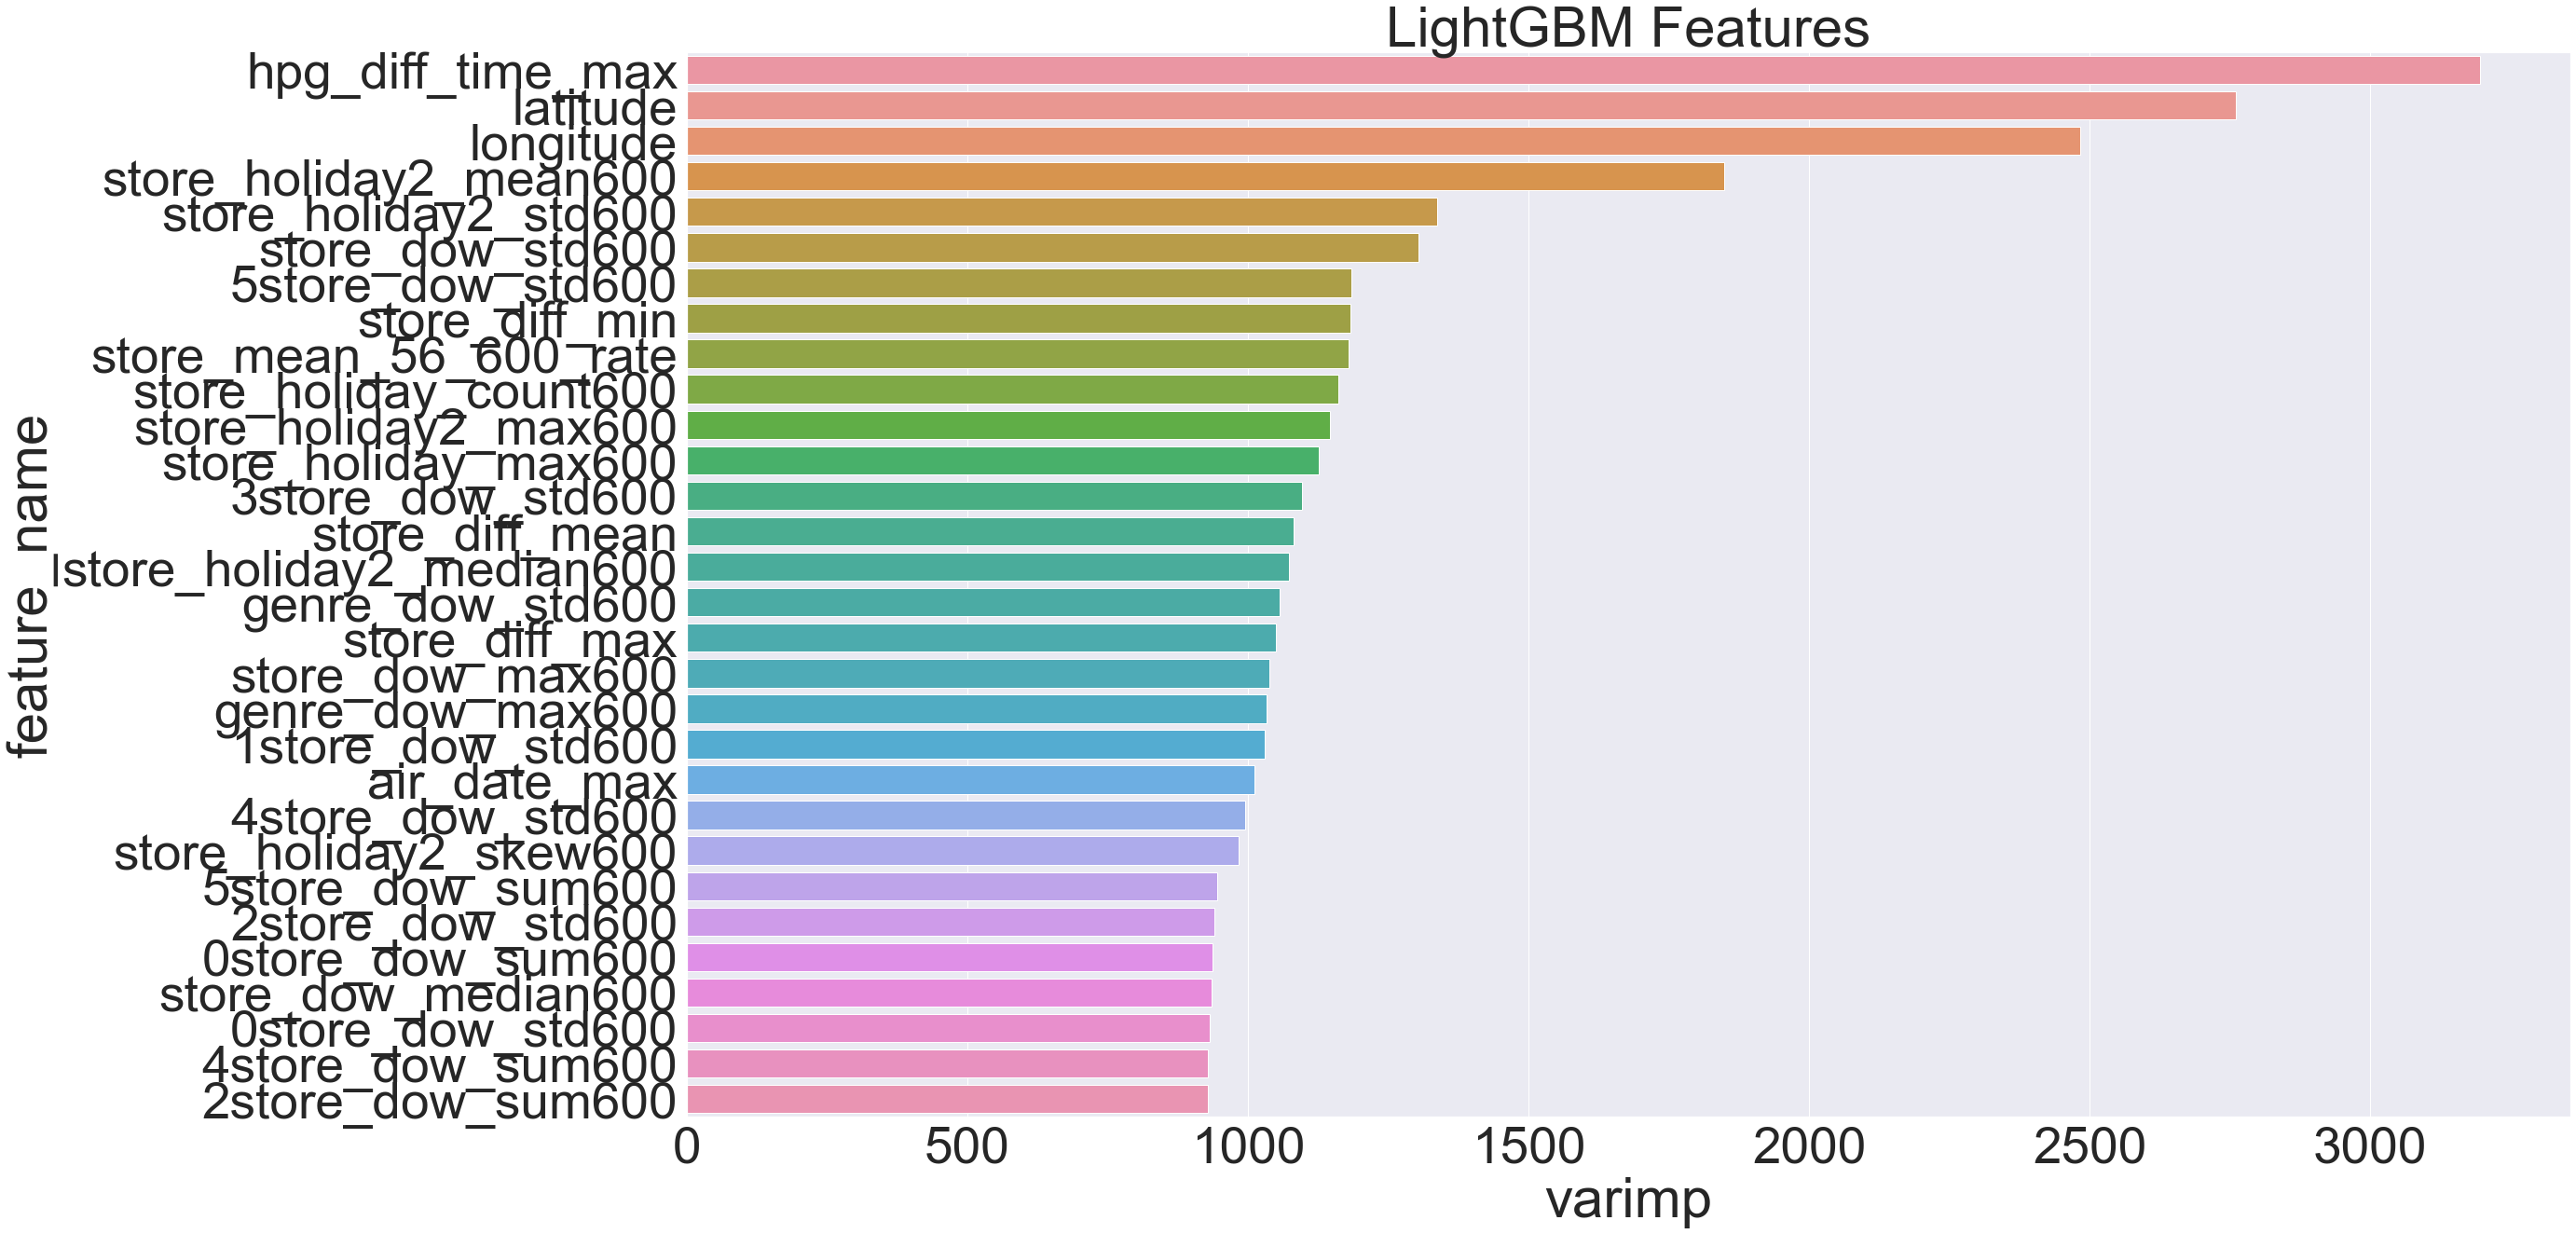

In [64]:
def plotImp(model, train_columns, max_vars=50):
    feature_imp = get_lgbm_varimp(model, train_columns, max_vars) 
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="varimp", y="feature_name", data=feature_imp)
#     plt.title('LightGBM Features (avg over folds)')
    plt.title('LightGBM Features')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

plotImp(lgbm, predictors, 30)

In [52]:
print('Total Modeling {} seconds'.format(time.time() - t0))

Total Modeling 1772.3570568561554 seconds


### Prediction

In [53]:
pred = lgbm.predict(test_feat[predictors])

In [59]:
subm = pd.DataFrame({'id':test_feat.store_id + '_' + test_feat.visit_date,'visitors':np.expm1(pred)})
subm = submission[['id']].merge(subm,on='id',how='left').fillna(0)

In [60]:
# # holiday trick
# """
# https://www.kaggle.com/c/recruit-restaurant-visitor-forecasting/discussion/49272
# https://www.kaggle.com/h4211819/holiday-trick
# """

# start_date = '2017-05-03'
# date_comb_1 = '2017-04-29'
# date_comb_2 = '2017-05-13'

# for day in range(3):
#     ans = date_add_days(start_date, day)
#     print (ans)
#     subm.loc[test_feat.visit_date==ans,'visitors'] = np.sqrt(subm.loc[test_feat.visit_date==date_comb_1,'visitors'].values * \
#                                                              subm.loc[test_feat.visit_date==date_comb_2,'visitors'].values)

# subm.loc[test_feat.visit_date==date_add_days(start_date, -1),'visitors'] = \
#     np.sqrt(subm.loc[test_feat.visit_date==date_add_days(date_comb_1, -1),'visitors'].values * \
#             subm.loc[test_feat.visit_date==date_add_days(date_comb_2, -1),'visitors'].values)

2017-05-03
2017-05-04
2017-05-05


In [61]:
subm.to_csv(r'data/sub{}.csv'.format(datetime.datetime.now().strftime('%Y%m%d_%H%M%S')),
                  index=False, float_format='%.4f')

In [62]:
subm

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,4.573533
1,air_00a91d42b08b08d9_2017-04-24,25.573820
2,air_00a91d42b08b08d9_2017-04-25,28.591556
3,air_00a91d42b08b08d9_2017-04-26,30.339613
4,air_00a91d42b08b08d9_2017-04-27,33.112220
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,6.366729
32015,air_fff68b929994bfbd_2017-05-28,3.645212
32016,air_fff68b929994bfbd_2017-05-29,3.068007
32017,air_fff68b929994bfbd_2017-05-30,3.852142
